In [29]:
import pandas as pd
import networkx as nx
import json
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt


In [37]:
with open("/content/processed_base_data.json", "r") as f:
    data = json.load(f)
df = pd.DataFrame(data)

with open("/content/trans-lines.json", "r") as f:
    lines = json.load(f)


In [38]:
G = nx.Graph()

for _, row in df.iterrows():
    G.add_node(
        row["nom"],
        lat=row["lat"],
        lon=row["lon"],
        adresse=row["adresse"],
        insee=row["insee"],
        desserte=row["desserte"],
        nbr_desserte=row["nbr_desserte"]
    )

# Add edges between consecutive stops per line
for line, stops in lines.items():
    for i in range(len(stops) - 1):
        s1, s2 = stops[i], stops[i + 1]
        # Check both stops exist in df
        if s1 in G.nodes and s2 in G.nodes:
            if G.has_edge(s1, s2):
                G[s1][s2]["lines"].add(line)
            else:
                G.add_edge(s1, s2, lines={line})

# Inspect network
print(f"Stops (nodes): {G.number_of_nodes()}")
print(f"Connections (edges): {G.number_of_edges()}")



Stops (nodes): 159
Connections (edges): 145


Stops (nodes): 159
Connections (edges): 145
Network density: 0.0115

Connected components: 40
Largest component size: 120 nodes

Centrality measures:
  Degree: {'Meyzieu Z.i.': 0.012658227848101266, 'Halles Paul Bocuse': 0.012658227848101266, 'Paul Berliet': 0.012658227848101266, '23 Août 1944': 0.0, 'Mions Libération': 0.0, 'Mions Croix Rouge': 0.0, 'Parc Nelson Mandela': 0.012658227848101266, 'Place Jean Jaurès': 0.02531645569620253, 'Perrache': 0.02531645569620253, 'Croix-Luizet': 0.012658227848101266, 'Décines Grand Large': 0.012658227848101266, 'Challemel Lacour Artill.': 0.0, 'Instit. Art Contemporain': 0.02531645569620253, 'Lenine - Corsiere': 0.0, 'Petite Guille': 0.0, 'Oullins Centre': 0.012658227848101266, 'Saint-Priest Salengro': 0.012658227848101266, 'Blanqui - Le Rize': 0.012658227848101266, 'Gare Saint-Paul': 0.006329113924050633, 'Parilly': 0.012658227848101266, 'Route de Mions': 0.0, 'Hénon': 0.012658227848101266, 'Valmy': 0.012658227848101266, 'Meyzieu Gare': 0.0126582

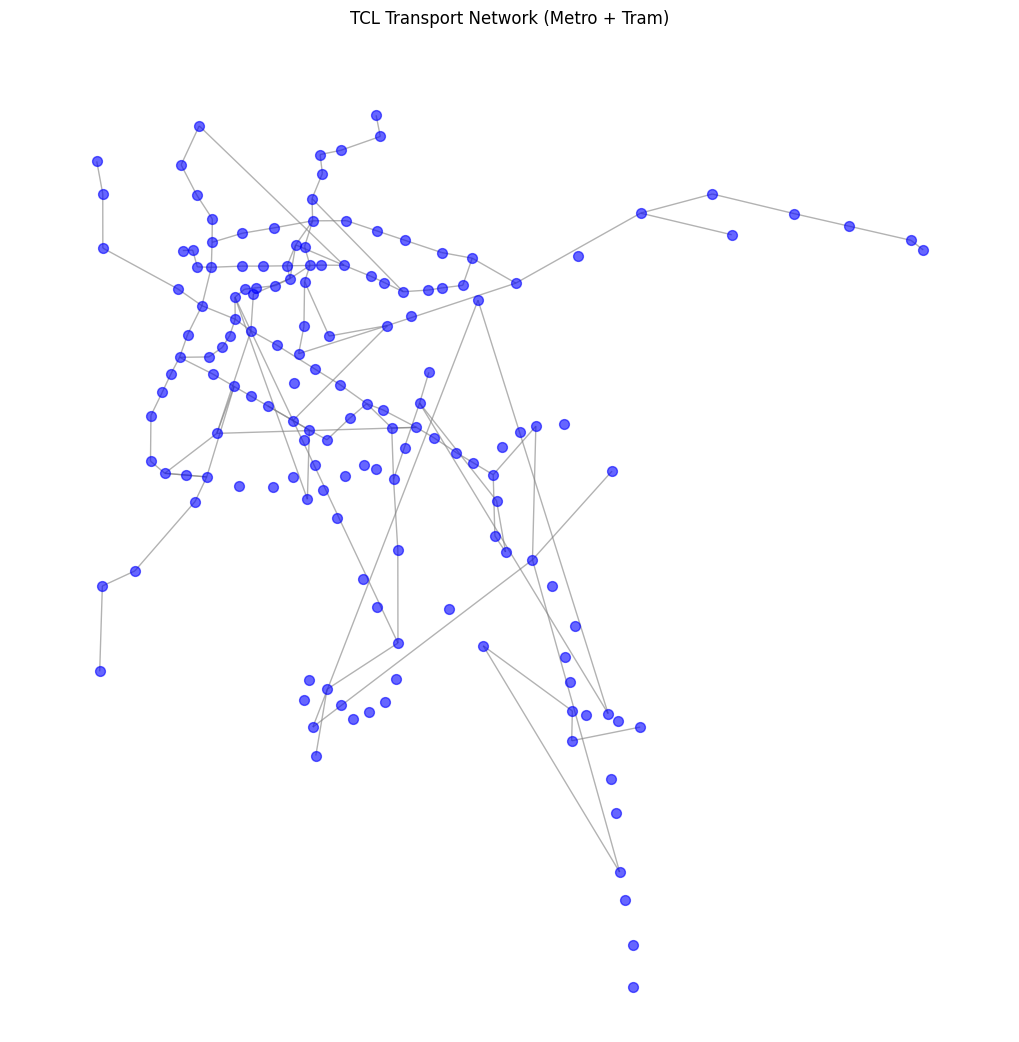

In [47]:
# Helper: haversine distance (km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Graph
print(f"Stops (nodes): {G.number_of_nodes()}")
print(f"Connections (edges): {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# Components
components = list(nx.connected_components(G))
print(f"\nConnected components: {len(components)}")
largest_cc = max(components, key=len)
print(f"Largest component size: {len(largest_cc)} nodes")

# Centrality
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight="weight")
closeness_centrality = nx.closeness_centrality(G, distance="weight")
print("\nCentrality measures:")
print(f"  Degree: {degree_centrality}")
print(f"  Betweenness: {betweenness_centrality}")
print(f"  Closeness: {closeness_centrality}")

top_deg = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_bet = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 stations by degree:")
for s, v in top_deg:
    print(f"  {s}: {v:.3f}")

print("Top 10 stations by betweenness:")
for s, v in top_bet:
    print(f"  {s}: {v:.3f}")


pos = {n: (G.nodes[n]['lon'], G.nodes[n]['lat']) for n in G.nodes}
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    node_size=50,
    node_color="blue",
    edge_color="gray",
    with_labels=False,
    alpha=0.6
)
plt.title("TCL Transport Network (Metro + Tram)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



In [ ]:
# exporting to Gephi
for u, v, data in G.edges(data=True):
    if isinstance(data.get("lines"), set):
        data["lines"] = ",".join(sorted(data["lines"]))

nx.write_gexf(G, "lyon_transport_network.gexf")
print("Exported to lyon_transport_network.gexf")



---



🔹 Communities detected: 48


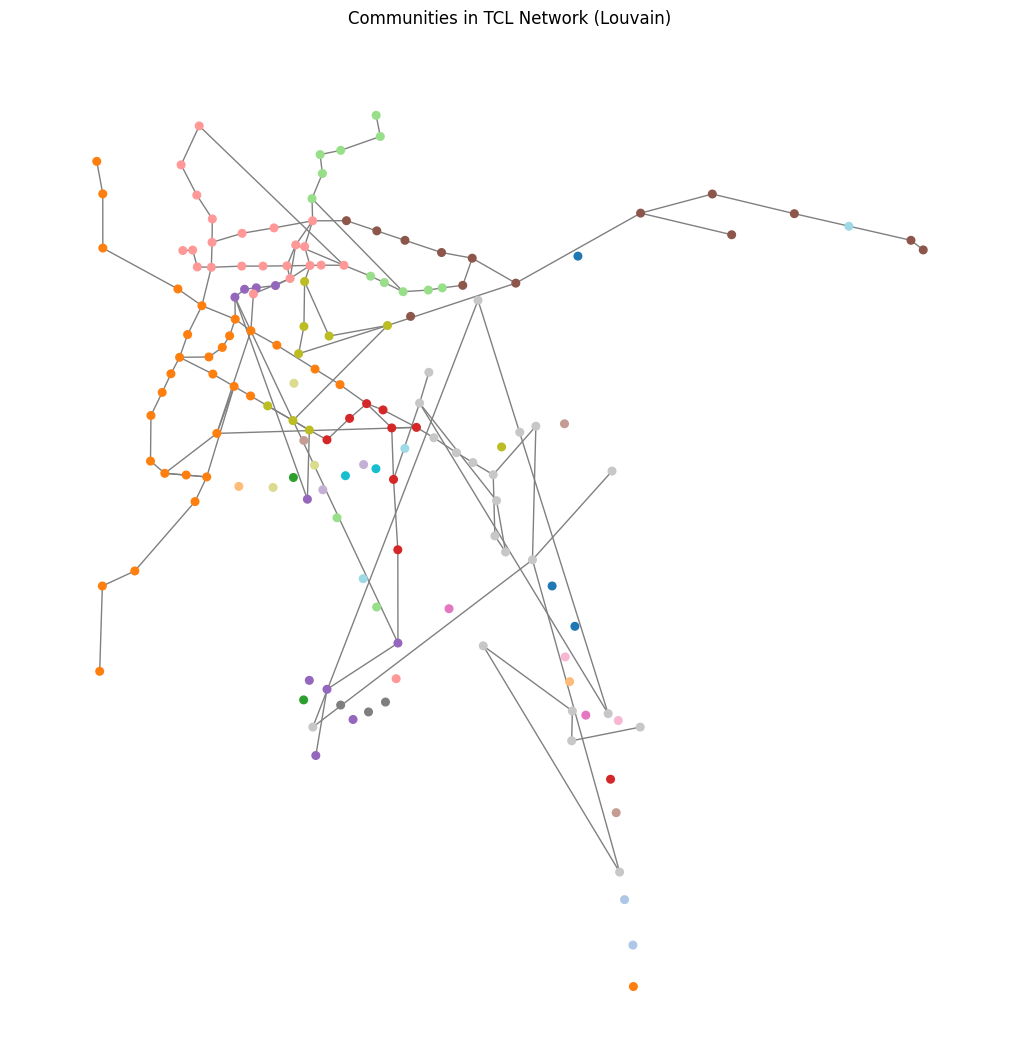

In [44]:
from community import community_louvain

partition = community_louvain.best_partition(G)
n_communities = len(set(partition.values()))

print(f"Communities detected: {n_communities}")

nx.set_node_attributes(G, partition, "community")

# Visualization
plt.figure(figsize=(10,10))
pos = {n: (G.nodes[n]["lon"], G.nodes[n]["lat"]) for n in G.nodes}
colors = [partition[n] for n in G.nodes]
nx.draw(G, pos, node_color=colors, node_size=30, edge_color="gray", with_labels=False, cmap=plt.cm.tab20)
plt.title("Communities in TCL Network (Louvain)")
plt.show()
